In [1]:
import pypsa 
import pandas as pd
import numpy as np

## Einlesen der Datenreihen

In [2]:
#infeed renewables
data_pv = pd.read_csv('data/data_pv_antofagasta_1MW.csv', skiprows = 3)['electricity']
data_wind = pd.read_csv('data/data_wind_antofagasta_1MW.csv', skiprows = 3)['electricity']
data_shipping_1 = pd.read_excel('data/Ferntransport.xlsx')['Kapazität [MWh]']
data_shipping_2 = 0

In [3]:
#Erstellung Lastprofil
hydrogen_demand = (35 * 1000) * 33 * 1000 # MWh
hydrogen_demand_hourly = hydrogen_demand/8760 #MW

In [4]:
electrolysis_profile_array = np.zeros(8760)
electrolysis_profile_raw = pd.DataFrame(electrolysis_profile_array)
electrolysis_profile = electrolysis_profile_raw.replace(0,1)

Multilink aufbauen

override_component_attrs = pypsa.descriptors.Dict(
    {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
)
override_component_attrs["Link"].loc["bus2"] = [
    "string",
    np.nan,
    np.nan,
    "2nd bus",
    "Input (optional)",
]
override_component_attrs["Link"].loc["efficiency2"] = [
    "static or series",
    "per unit",
    1.0,
    "2nd bus efficiency",
    "Input (optional)",
]
override_component_attrs["Link"].loc["p2"] = [
    "series",
    "MW",
    0.0,
    "2nd bus output",
    "Output",
]

## Definition der Variablen

In [5]:
p_nom_pv = data_pv.max()
p_nom_wind = data_wind.max()

#### Investitionskosten

In [6]:
# generators
capital_cost_pv = 1000 # €/MW
capital_cost_wind = 1000 # €/MW

# links
capital_cost_PEMEL = 1000 # €/MW
capital_cost_AEL = 1200 # €/MW
capital_cost_HTEL = 1300 # €/MW
capital_cost_NH3 = 1400 # €/MW
capital_cost_LH2 = 1500 # €/MW
capital_cost_LHOC = 1600 # €/MW
capital_cost_pipeline = 5000 # €/MW
capital_cost_shipping_1 = 100000 # €/MW
capital_cost_shipping_2 = 80000 # €/MW

# storages
capital_cost_storage_GH2 = 20 # €/MW
capital_cost_storage_NH3 = 20 # €/MW
capital_cost_storage_LH2 = 20 # €/MW
capital_cost_storage_LHOC = 20 # €/MW

#### Gestehungskosten

In [7]:
# generators
marginal_cost_pv = 70 # €/MWh
marginal_cost_wind = 70 # €/MWh

# conversion
marginal_cost_PEMEL = 100 # €/MWh
marginal_cost_AEL = 100 # €/MWh
marginal_cost_HTEL = 100 # €/MWh
marginal_cost_NH3 = 100 # €/MWh
marginal_cost_LH2 = 100 # €/MWh
marginal_cost_LHOC = 100 # €/MWh

# storage
marginal_cost_storage_GH2 = 20 # €/MWh
marginal_cost_storage_NH3 = 20 # €/MWh
marginal_cost_storage_LH2 = 20 # €/MWh
marginal_cost_storage_LHOC = 20 # €/MWh

# transportation
marginal_cost_pipeline = 200 # €/MWh
marginal_cost_shipping_GH2 = 10 # €/MWh
marginal_cost_shipping_NH3 = 10 # €/MWh
marginal_cost_shipping_LH2 = 10 # €/MWh
marginal_cost_shipping_LHOC = 10 # €/MWh

#### Sonstiges

In [8]:
# efficiencies
efficiency_PEMEL = 1
efficiency_AEL = 1
efficiency_HTEL = 1
efficiency_NH3 = 1
efficiency_LH2 = 1
efficiency_LHOC = 1

# lifetimes
lifetime_PEMEL = 20
lifetime_AEL = 20
lifetime_HTEL = 20

# standing losses
standing_loss_GH2 = 0.05
standing_loss_NH3 = 0.05
standing_loss_LH2 = 0.05
standing_loss_LHOC = 0.05

## Netzwerk aufbauen

In [9]:
network = pypsa.Network()
network.set_snapshots(range(8760))

#### Buses

In [10]:
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'GH2')
#network.add('Bus', name = 'NH3')
#network.add('Bus', name = 'LH2')
#network.add('Bus', name = 'LHOC')
#network.add('Bus', name = 'hydrogen')

network.add('Bus', name = 'bremerhaven')
#network.add('Bus', name = 'cologne')

#### Loads

In [11]:
network.add('Load', name = 'hydrogen_demand', bus = 'bremerhaven', p_set = hydrogen_demand_hourly)

#### Generators

In [12]:
network.add('Generator', name = 'pv', bus = 'electricity', 
            p_nom = p_nom_pv, p_max_pu = data_pv/data_pv.max(), p_nom_extendable = True,
            marginal_cost = marginal_cost_pv, capital_cost = capital_cost_pv)

network.add('Generator', name = 'wind', bus = 'electricity',
            p_nom =  p_nom_wind, p_max_pu = data_wind/data_wind.max(), p_nom_extendable = True,
            marginal_cost = marginal_cost_wind, capital_cost = capital_cost_wind)

#### Links - Electrolysis

In [13]:
network.add('Link', name = 'PEMEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom = 1, p_nom_extendable = True, 
           marginal_cost = marginal_cost_PEMEL, capital_cost = capital_cost_PEMEL,
           efficiency = efficiency_PEMEL)

network.add('Link', name = 'AEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_AEL, capital_cost = capital_cost_AEL,
           efficiency = efficiency_AEL)
network.add('Link', name = 'HTEL', bus0 = 'electricity', bus1 = 'GH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_HTEL, capital_cost = capital_cost_HTEL,
           efficiency = efficiency_HTEL)

#### Links - Conversion

network.add('Link', name = 'NH3', bus0 = 'electricity', bus1 = 'NH3',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_NH3, capital_cost = capital_cost_NH3,
           efficiency = efficiency_NH3)

network.add('Link', name = 'LH2', bus0 = 'electricity', bus1 = 'LH2',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LH2, capital_cost = capital_cost_LH2,
           efficiency = efficiency_LH2)

network.add('Link', name = 'LHOC', bus0 = 'electricity', bus1 = 'LHOC',
           p_nom_extendable = True,
           marginal_cost = marginal_cost_LHOC, capital_cost = capital_cost_LHOC,
           efficiency = efficiency_LHOC)

#### Links - Transportation

In [14]:
# long distance shipment
network.add('Link', name = 'Ferntransport_GH2', bus0 = 'GH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(), p_nom_extendable = True,
            marginal_cost = marginal_cost_shipping_GH2, capital_cost = capital_cost_shipping_1)

In [15]:
(data_shipping_1.sum()/4)/(33*1000*1000)

8.75

In [16]:
hydrogen_demand

1155000000

network.add('Link', name = 'Ferntransport_NH3', bus0 = 'NH3', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_NH3)

network.add('Link', name = 'Ferntransport_LH2', bus0 = 'LH2', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LH2)

network.add('Link', name = 'Ferntransport_LHOC', bus0 = 'LHOC', bus1 = 'bremerhaven',
            p_nom = data_shipping_1.max(), p_max_pu = data_shipping_1/data_shipping_1.max(),
            marginal_cost = marginal_cost_shipping_LHOC)

# inland shipment
#TODO: Profil hinterlegen und Links einbauen

#### Storages

In [17]:
network.add('Store', name = 'antofagasta_GH2', bus = 'GH2', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'hydrogen_store_1.1', bus = 'NH3', 
            e_nom_extendable = True,  e_cyclic = True, 
            capital_cost = capital_cost_storage_NH3)

network.add('Store', name = 'hydrogen_store_1.2', bus = 'LH2', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LH2)

network.add('Store', name = 'hydrogen_store_1.3', bus = 'LHOC', 
            e_nom_extendable = True, e_cyclic = True,  
            capital_cost = capital_cost_storage_LHOC)

network.add('Store', name = 'bremerhaven_GH2', bus = 'bremerhaven', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

network.add('Store', name = 'cologne_GH2', bus = 'cologne', 
            e_nom_extendable = True, e_cyclic = True, 
            capital_cost = capital_cost_storage_GH2)

## Optimierung des Systems

In [18]:
network.lopf(pyomo = False, solver_name = 'gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 1.14s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-01
Read LP format model from file /var/folders/np/fxyv4bts2s353fj5gdlrbgym0000gn/T/pypsa-problem-9vq_nlk6.lp
Reading time = 0.59 seconds
obj: 254040 rows, 140171 columns, 477933 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 254040 rows, 140171 columns and 477933 nonzeros
Model fingerprint: 0x1ba5b65f
Coefficient statistics:
  Matrix range     [1e-06, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [2e+11, 2e+11]
  RHS range        [1e+05, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 210358 rows and 122684 columns
Presolve time: 0.52s
Presolved: 43682 rows, 17487 columns, 121171 nonze

INFO:pypsa.linopf:Optimization successful. Objective value: 2.23e+11


('ok', 'optimal')

## Auswertung der Ergebnisse

In [19]:
network.generators.p_nom_opt

Generator
pv      645679.62869
wind         0.00000
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

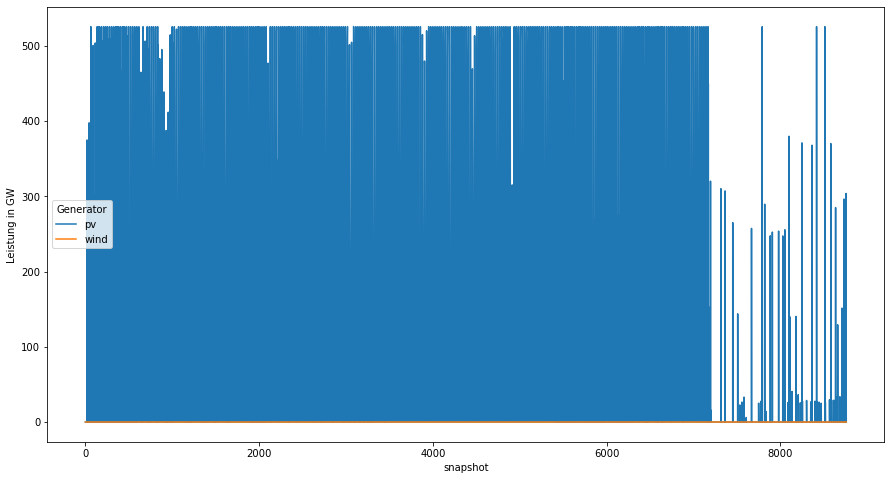

In [20]:
(network.generators_t.p/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

In [21]:
network.links_t.p0[2400:2424]

Link,PEMEL,Ferntransport_GH2
snapshot,,
2400,0.000000,0.0
2401,0.000000,0.0
2402,0.000000,0.0
2403,0.000000,0.0
2404,0.000000,0.0
2405,0.000000,0.0
2406,0.000000,0.0
2407,0.000000,0.0
2408,0.000000,0.0


In [22]:
network.links.p_nom_opt/1000

Link
PEMEL                 525.275874
Ferntransport_GH2    1887.254902
Name: p_nom_opt, dtype: float64

In [23]:
network.links.p_nom/1000

Link
PEMEL                   0.001000
Ferntransport_GH2    1887.254902
Name: p_nom, dtype: float64

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

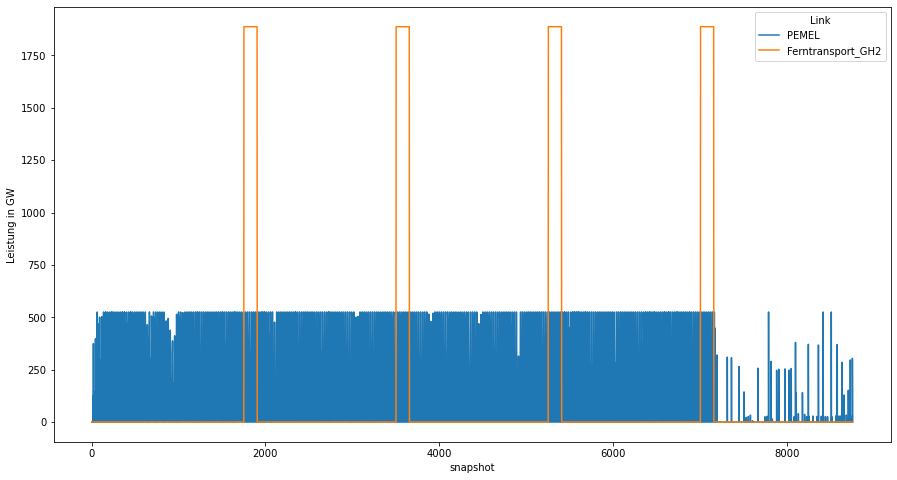

In [24]:
(network.links_t.p0/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

<AxesSubplot:xlabel='snapshot', ylabel='Leistung in GW'>

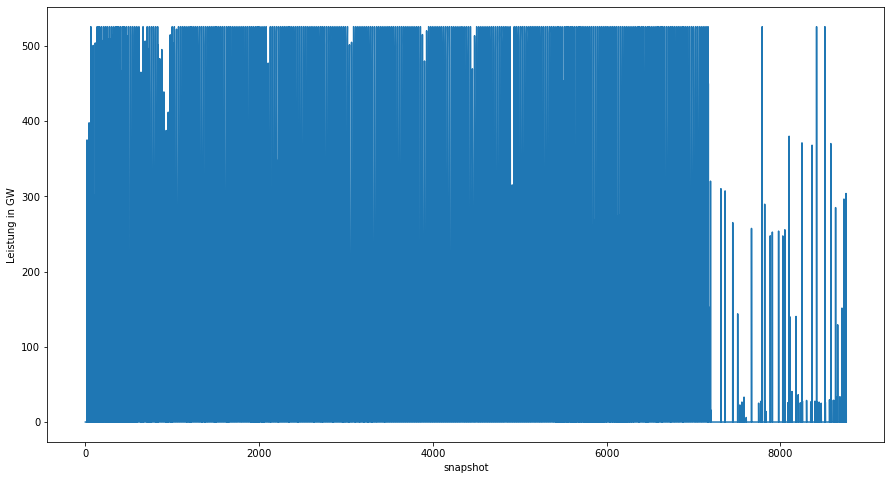

In [25]:
(network.links_t.p0['PEMEL']/1000).plot(figsize = (15,8), ylabel = 'Leistung in GW')

In [26]:
network.stores.e_nom_opt

Store
antofagasta_GH2       2.645526e+08
hydrogen_store_1.1    0.000000e+00
hydrogen_store_1.2    0.000000e+00
hydrogen_store_1.3    0.000000e+00
bremerhaven_GH2       4.418271e+08
cologne_GH2           0.000000e+00
Name: e_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

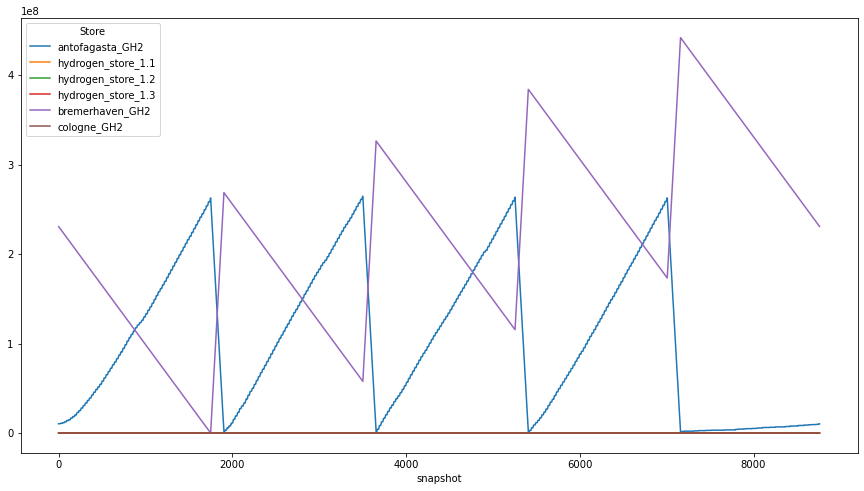

In [27]:
network.stores_t.e.plot(figsize = (15,8))